## Make the big matrices with residue msa canonical number as columns and interactions as rows 
### One matrix for each ligand-protein pair

In [1]:
import json
import pandas as pds
import numpy as np
from pathlib import Path
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
ligand_interactions = dict()
with open('/home/pengs/fold_zika/oddt_dock/plip_ligand_interactions.json', 'r') as f:
    ligand_interactions = json.load(f)
    
interactions = ["hydrophobic_interaction", 
                "hydrogen_bond", 
                "water_bridge", 
                "salt_bridge", 
                "pi_stack", 
                "pi_cation_interaction", 
                "halogen_bond", 
                "metal_complex"]
interactions_index = dict()
index = 1
for inter in interactions:
    interactions_index[inter] = index
    index += 1

In [3]:
# Read in the MSA mappint of canonical number to pdb residue id
msa_map = dict()
with open('/home/pengs/fold_zika/oddt_dock/msa_map.json', 'r') as f:
    msa_map = json.load(f)

In [4]:
# Return a list of all the files in input directory and and layered directory inside
def traverse_files(directory):
    all_files = []
    # Traverse files within a directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            all_files.append(file)
    return all_files

## Would like to know if they are iteracting with the same residues on the protein
### Would need to map back to the canonical numbering made from MSA for each of the residues
### Would need to make a matrix for each of the ligands with one axis being the residue msa number and the other being the interactions that are perceived
#### The matrix will be super sparse because only there are only a very few number of residues interacting with the ligands
#### Would need to find a way to compare the matrices (I dont think my current jaccard index is going to cut it because I feel like it requires the data being fed in to be 1d)
#### Tanimoto score references
https://python.plainenglish.io/how-to-find-an-intersection-between-two-matrices-easily-using-numpy-30263373b546
https://stackoverflow.com/questions/49338166/python-intersection-over-union

## Make a matrix for all ligand and protein pairs

In [5]:
# Make a dictionary of dictionary with fingerprint with all residues considered
# Dictionary of ligands with each proteins stored inside
# Each vector is a type of interaction, each position in the vector represent an interaction 
# Create bitmap where 1 is representing the interaction is present while 0 represent absence
lig_prot_bitmap = dict()

for lig in ligand_interactions:
    lig_prot_bitmap[lig] = dict()
    for prot in ligand_interactions[lig]:
        # Matching the format to put into fingerprint matrix
        list2 = []
        for inters in ligand_interactions[lig][prot][2]:
            list2.append(interactions_index[inters])
            
        list1 = ligand_interactions[lig][prot][1]
        # Create a matrix for storing fingerprint
        matrix = np.zeros((8, 195))
        
        # Fill in the matrix
        for i in range(len(list1)):
            column_index = int(list1[i])
            row_index = int(list2[i])
            matrix[row_index - 1, column_index - 1] = 1
        
        lig_prot_bitmap[lig][prot] = matrix

## Compare the interactions between interactions of original crystal structure and colabfold docked structure
score = and/reference + new ## This is not going to work because it would be weighing the new interactions too high

tanimoto = and/or

In [6]:
ref = 'zikv_ns2b3'
prots_dir = Path('/home/pengs/fold_zika/only_prot')
prot_file_list = traverse_files(prots_dir)
fold_prot_list = []
for prot_file in prot_file_list:
    prot = Path(prot_file).stem
    if prot == ref:
        continue
    fold_prot_list.append(prot)

In [7]:
## Calculate Tanimoto Scores between each pair
tanimoto_maps = dict()

In [8]:
for lig in ligand_interactions:
    tanimoto_maps[lig] = dict()
    ref_matrix = ligand_interactions[lig][ref]
    for prot in ligand_interactions[lig]:
        # Don't want to compare to itself
        if prot == ref:
            continue
        logic_and = np.logical_and(lig_prot_bitmap[lig][prot],lig_prot_bitmap[lig][ref])
        logic_or = np.logical_or(lig_prot_bitmap[lig][prot],lig_prot_bitmap[lig][ref])
        # Save under the protein being compared to reference
        tanimoto_maps[lig][prot] = np.sum(logic_and)/np.sum(logic_or)

/scratch/lsftmp/5517311.tmpdir/ipykernel_126924/725731113.py:11: RuntimeWarning: invalid value encountered in long_scalars
  tanimoto_maps[lig][prot] = np.sum(logic_and)/np.sum(logic_or)


In [9]:
tanimoto_maps

{'14': {'NP_776018.1': 0.14285714285714285,
  'YP_001527884.1': 0.14285714285714285,
  'YP_001531172.2': 0.16666666666666666,
  'NP_739587.2': 0.1111111111111111,
  'NP_722463.1': 0.14285714285714285,
  'NP_740321.1': 0.0,
  'YP_001621843.1': 0.14285714285714285},
 '46': {'NP_776018.1': 0.0,
  'YP_001527884.1': 0.0,
  'YP_001531172.2': 0.0,
  'NP_739587.2': 0.0,
  'NP_722463.1': 0.0,
  'NP_740321.1': 0.0,
  'YP_001621843.1': 0.0},
 '36': {'NP_776018.1': 0.5,
  'YP_001527884.1': 0.14285714285714285,
  'YP_001531172.2': 0.3333333333333333,
  'NP_739587.2': 0.3333333333333333,
  'NP_722463.1': 0.3333333333333333,
  'NP_740321.1': 0.16666666666666666,
  'YP_001621843.1': 0.16666666666666666},
 '37': {'NP_776018.1': 0.4,
  'YP_001527884.1': 0.4,
  'YP_001531172.2': 0.16666666666666666,
  'NP_739587.2': 0.16666666666666666,
  'NP_722463.1': 0.0,
  'NP_740321.1': 0.16666666666666666,
  'YP_001621843.1': 0.4},
 '11': {'NP_776018.1': 0.0,
  'YP_001527884.1': 0.0,
  'YP_001531172.2': 0.0,
  'NP_

<Axes: >

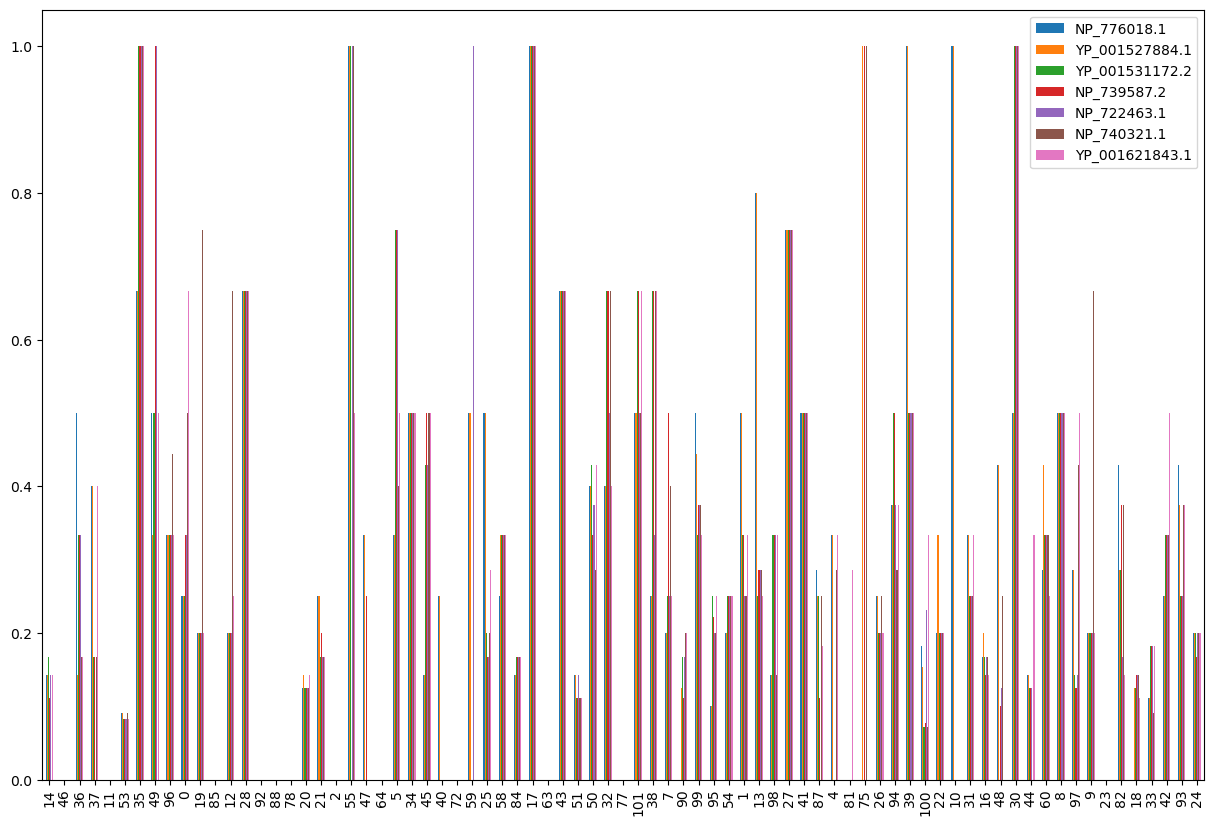

In [10]:
tanimoto_df = pds.DataFrame(tanimoto_maps).T
tanimoto_df.plot.bar(figsize=(15,10))

## This may be a bit of an issue because if there are less interactions being made, more likely to have similar interactions

In [11]:
tanimoto_summary = pds.DataFrame()
tanimoto_summary['std'] = tanimoto_df.std(axis=1) 
tanimoto_summary['mean'] = tanimoto_df.mean(axis=1)

In [12]:
tanimoto_summary = tanimoto_summary.sort_index()

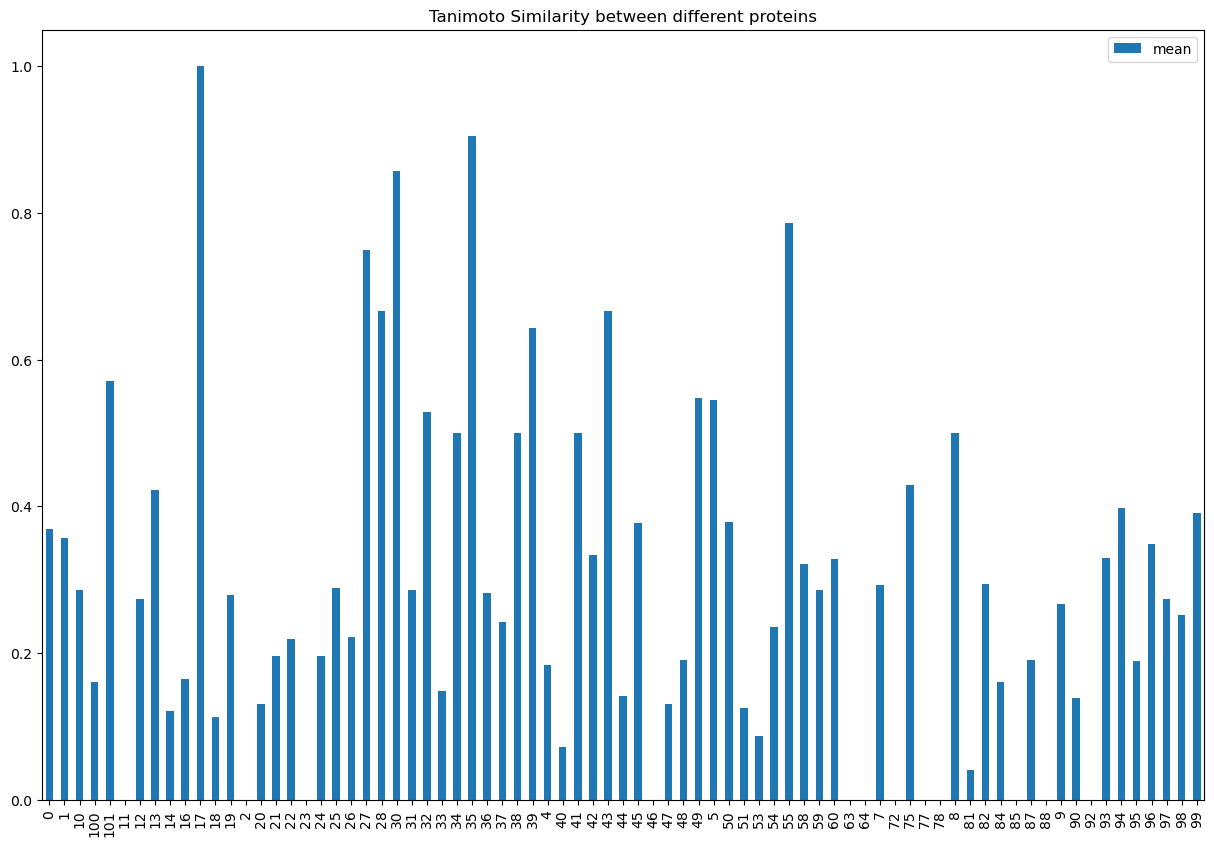

In [13]:
ax = tanimoto_summary.plot(kind = "bar", y = "mean",figsize=(15,10), title = 'Tanimoto Similarity between different proteins')
                      #yerr = "std",figsize=(15,10))

fig_dir = Path('/home/pengs/fold_zika/figures')
fig = ax.get_figure()
fig.savefig(fig_dir/'tanimoto_similarity.png', dpi=300)

## Homebrew Score

$$
\frac{\text{conserved interactions}}{\text{original interactions}} + \mu \cdot c
$$

In [14]:
# Function 
def homebrew_score(bitmap,ligand_interactions, mu):
    union_ref_maps = dict()

    for lig in ligand_interactions:
        union_ref_maps[lig] = dict()
        ref_matrix = ligand_interactions[lig][ref]
        for prot in ligand_interactions[lig]:
            # Don't want to compare to itself
            if prot == ref:
                continue
            logic_and = np.logical_and(bitmap[lig][prot],bitmap[lig][ref])
            logic_or = np.logical_or(bitmap[lig][prot],bitmap[lig][ref])
            # Save under the protein being compared to reference
            con_orig = np.sum(logic_and)/np.sum(bitmap[lig][ref])
            new = np.sum(logic_or) - np.sum(bitmap[lig][ref])
            union_ref_maps[lig][prot] = con_orig + mu*new
    return union_ref_maps

In [15]:
## Calculate homebrew scores of conserved interactions as a percent of interactions in reference between each pair
union_ref_maps = dict()

for lig in ligand_interactions:
    union_ref_maps[lig] = dict()
    ref_matrix = ligand_interactions[lig][ref]
    for prot in ligand_interactions[lig]:
        # Don't want to compare to itself
        if prot == ref:
            continue
        logic_and = np.logical_and(lig_prot_bitmap[lig][prot],lig_prot_bitmap[lig][ref])
        # Save under the protein being compared to reference
        union_ref_maps[lig][prot] = np.sum(logic_and)/np.sum(lig_prot_bitmap[lig][ref])

/scratch/lsftmp/5517311.tmpdir/ipykernel_126924/425815747.py:13: RuntimeWarning: invalid value encountered in double_scalars
  union_ref_maps[lig][prot] = np.sum(logic_and)/np.sum(lig_prot_bitmap[lig][ref])


<Axes: >

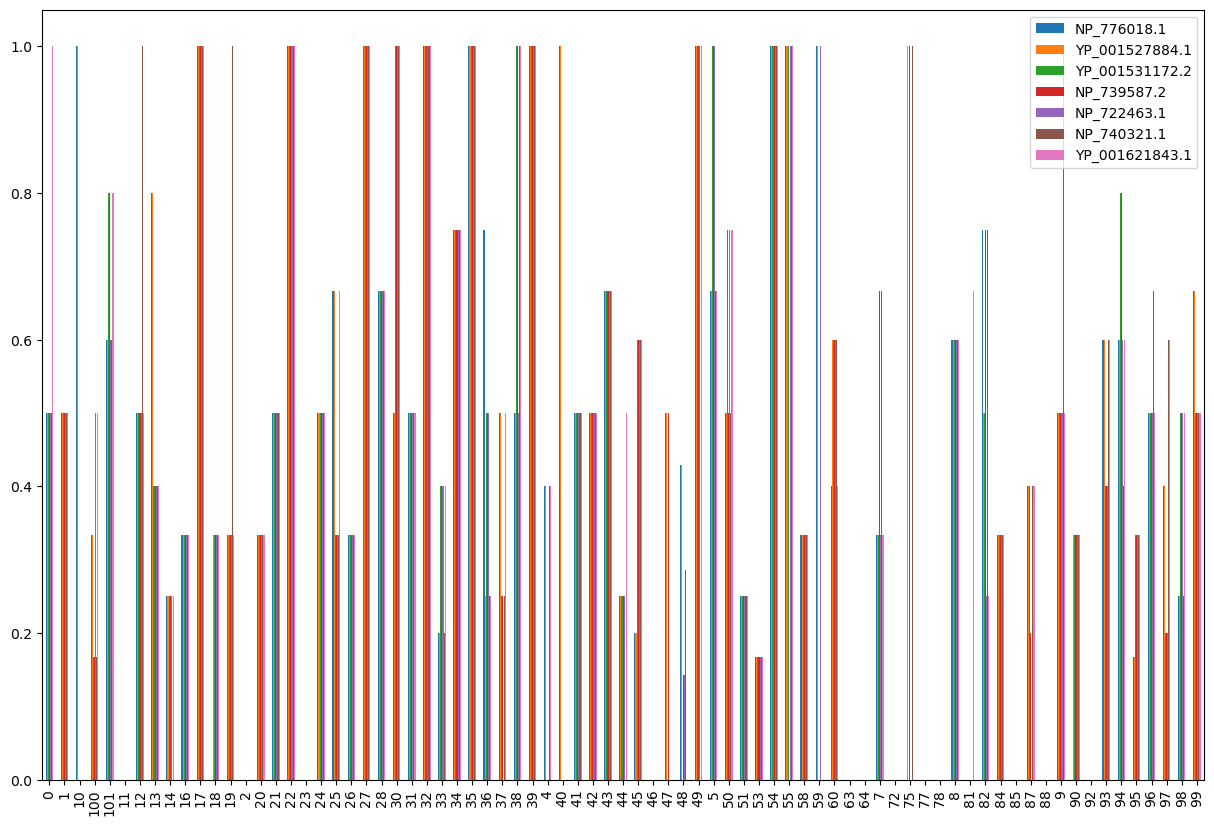

In [16]:
union_ref_df = pds.DataFrame(union_ref_maps).T
union_ref_df = union_ref_df.sort_index()
union_ref_df.plot.bar(figsize=(15,10))

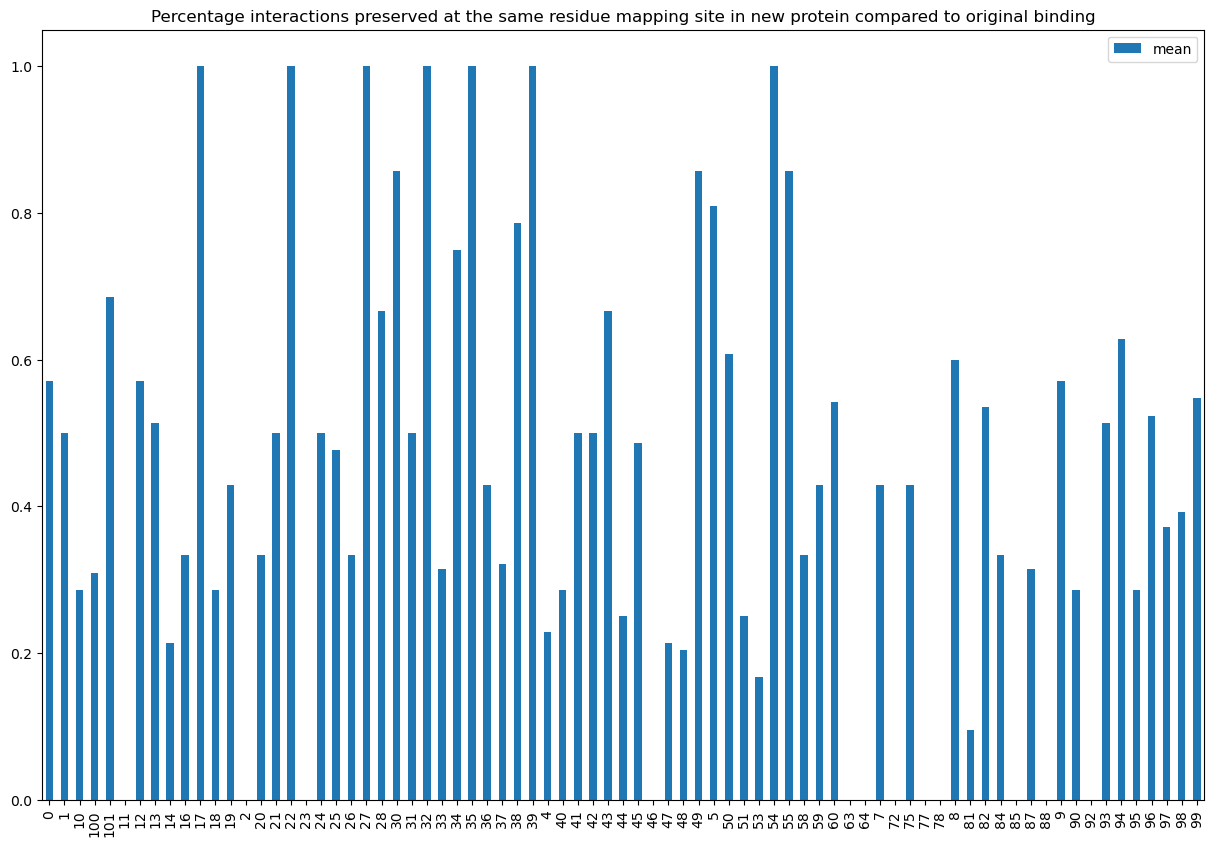

In [17]:
union_ref_summary = pds.DataFrame()
union_ref_summary['std'] = union_ref_df.std(axis=1) 
union_ref_summary['mean'] = union_ref_df.mean(axis=1)
union_ref_summary = union_ref_summary.sort_index()

ax = union_ref_summary.plot(kind = "bar", y = "mean",figsize=(15,10), title = 'Percentage interactions preserved at the same residue mapping site in new protein compared to original binding')
                      #yerr = "std",figsize=(15,10))

fig = ax.get_figure()
fig.savefig(fig_dir/'union_reference_similarity.png', dpi=300)

### Test if there are difference in terms of weighing the importance put on new interactions with new protein

In [18]:
mu_scores = dict()
for mu in np.arange(0, 1.1, 0.1):
    mu_scores[mu] = homebrew_score(lig_prot_bitmap,ligand_interactions, mu)

/scratch/lsftmp/5517311.tmpdir/ipykernel_126924/2740044673.py:15: RuntimeWarning: invalid value encountered in double_scalars
  con_orig = np.sum(logic_and)/np.sum(bitmap[lig][ref])


In [19]:
def plot_interactions(union_ref_maps):
    union_ref_df = pds.DataFrame(union_ref_maps).T
    union_ref_df = union_ref_df.sort_index()
    union_ref_df.plot.bar(figsize=(15,10), title = f'{mu}')

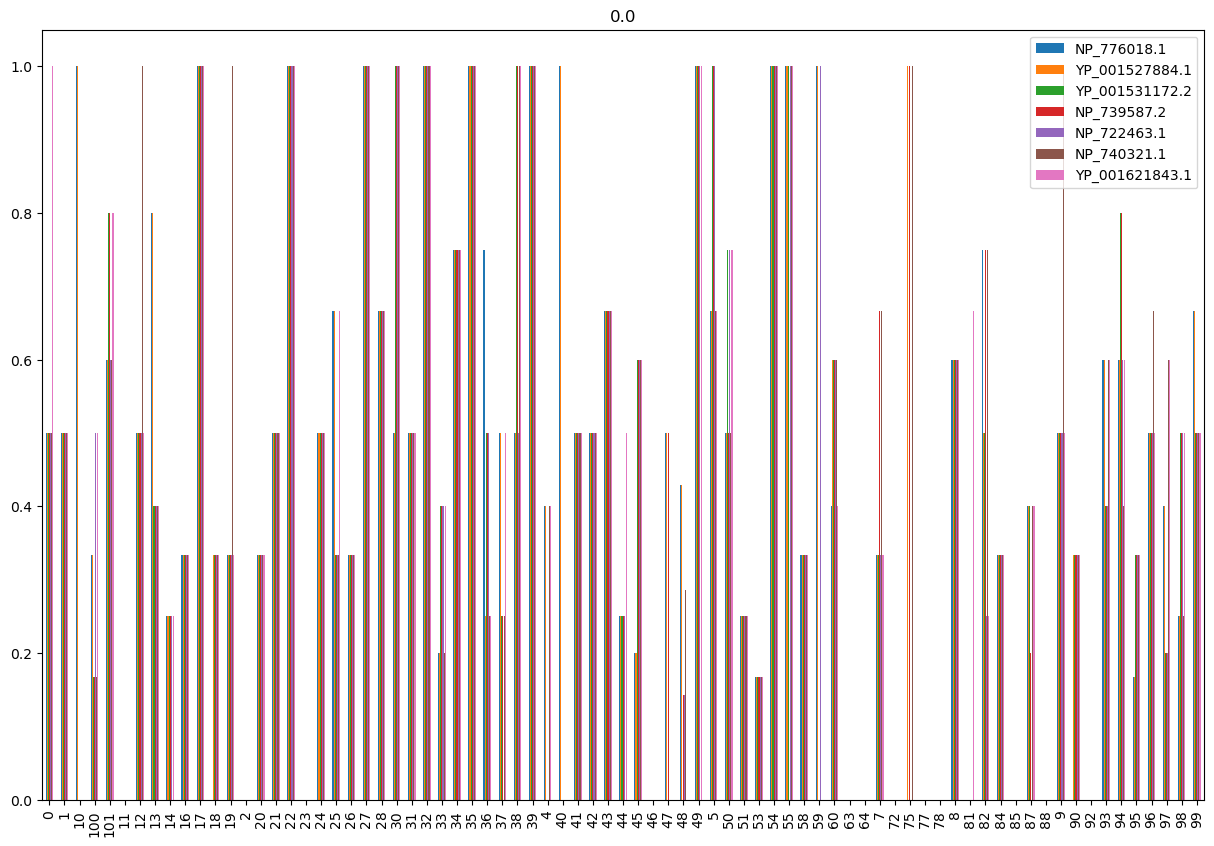

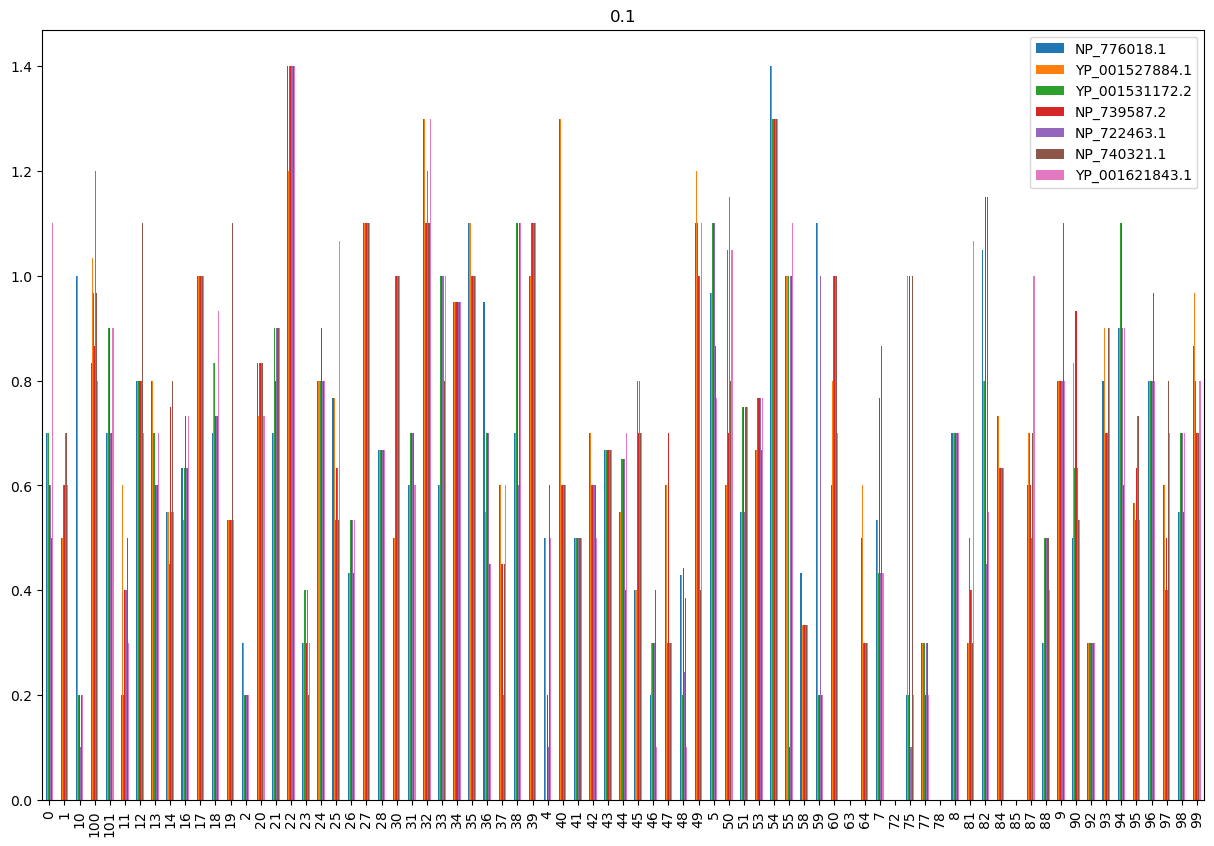

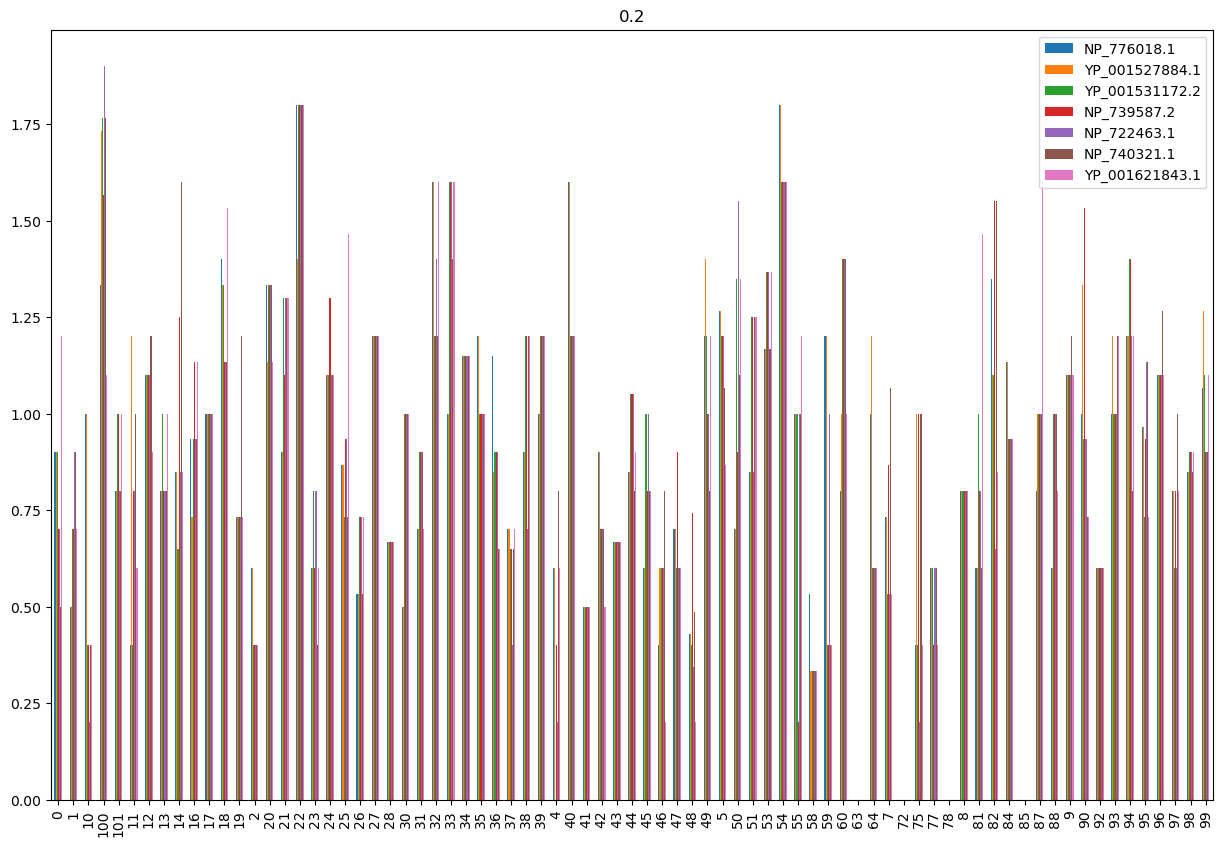

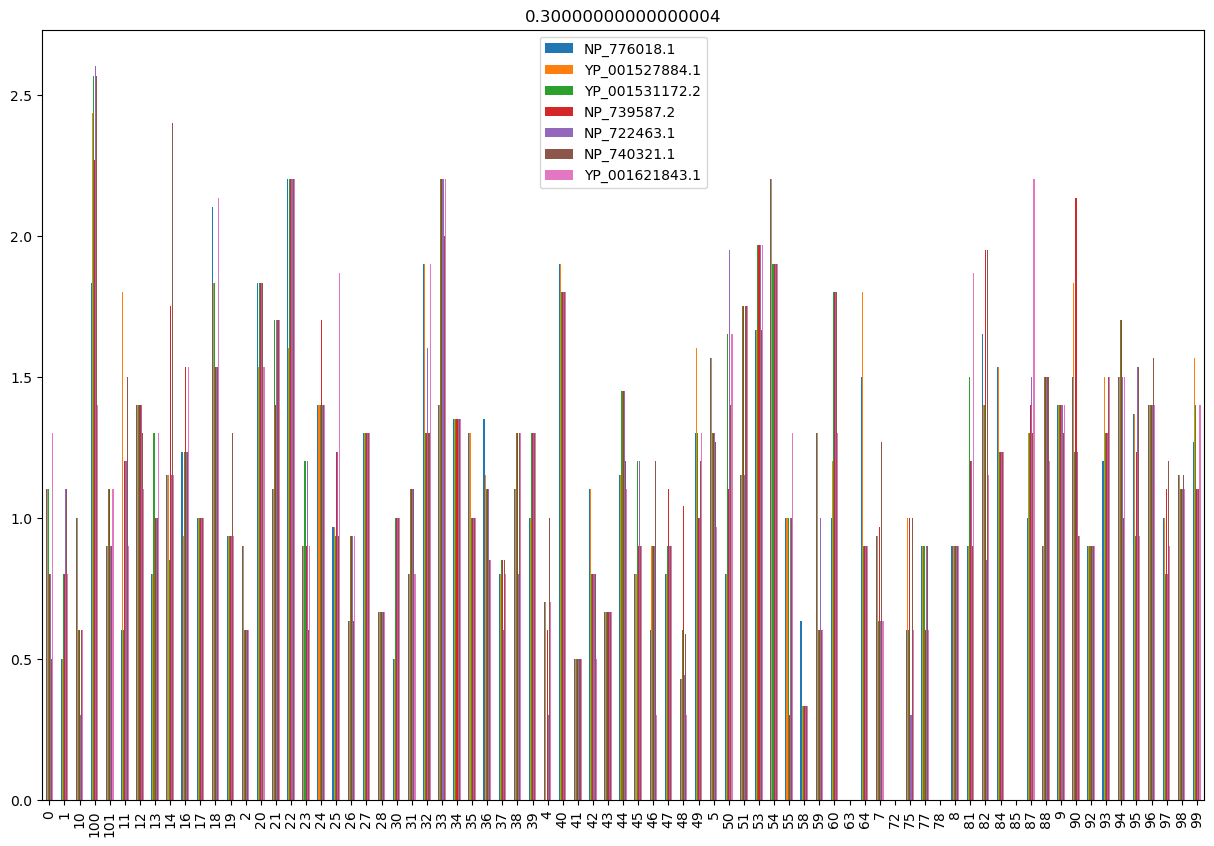

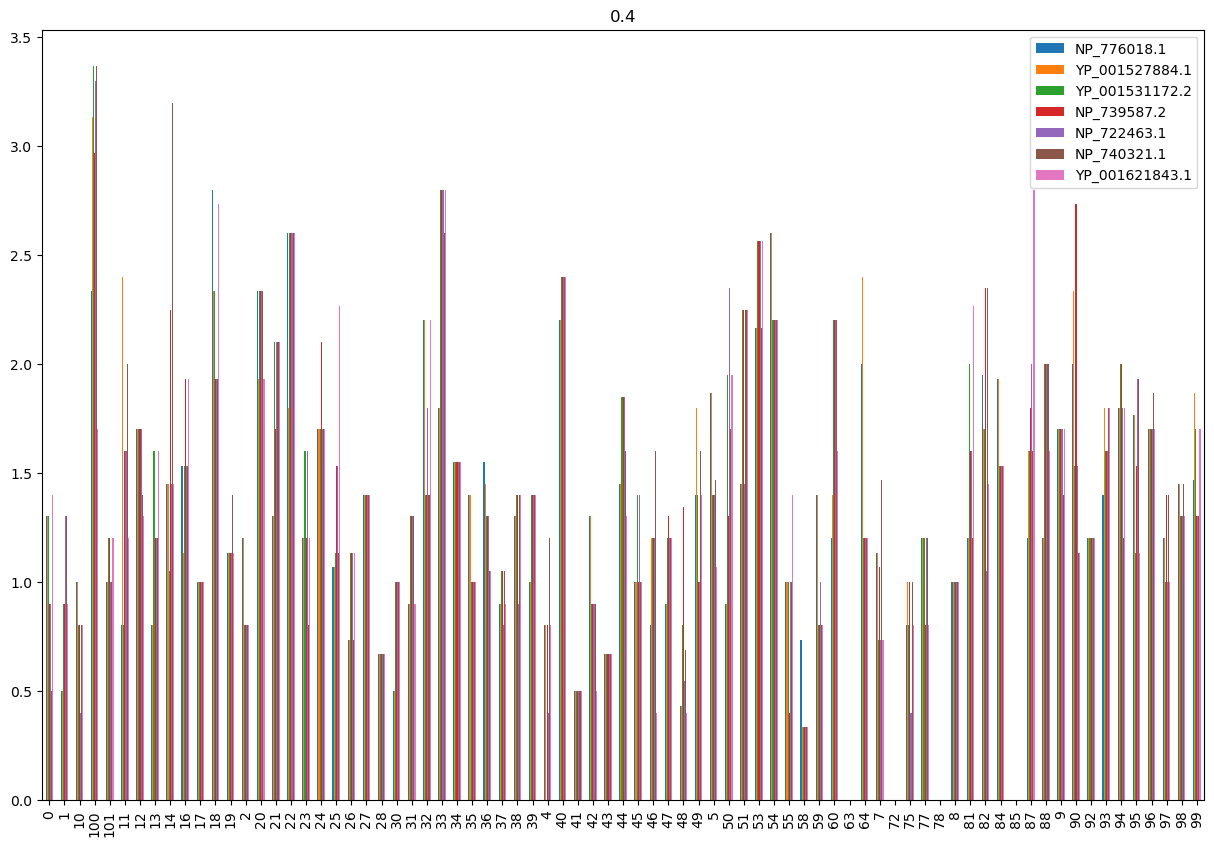

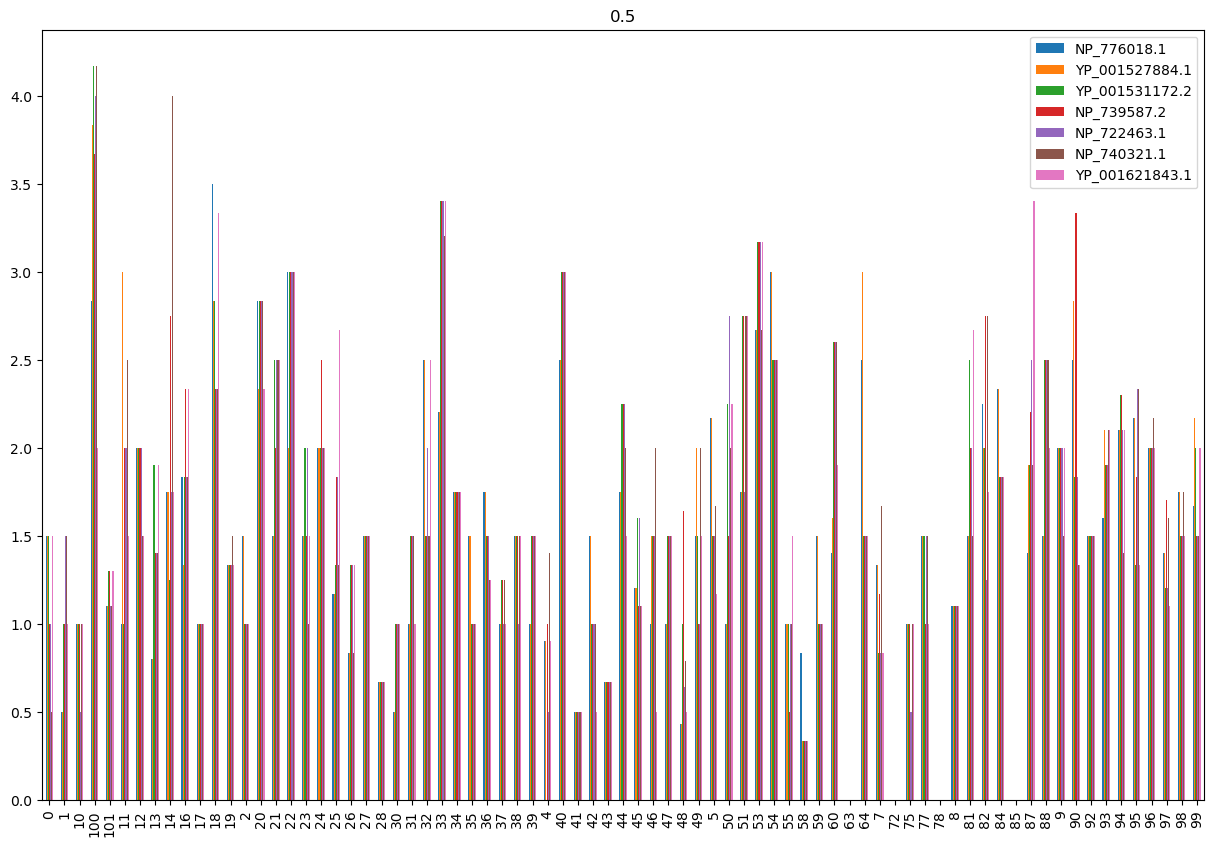

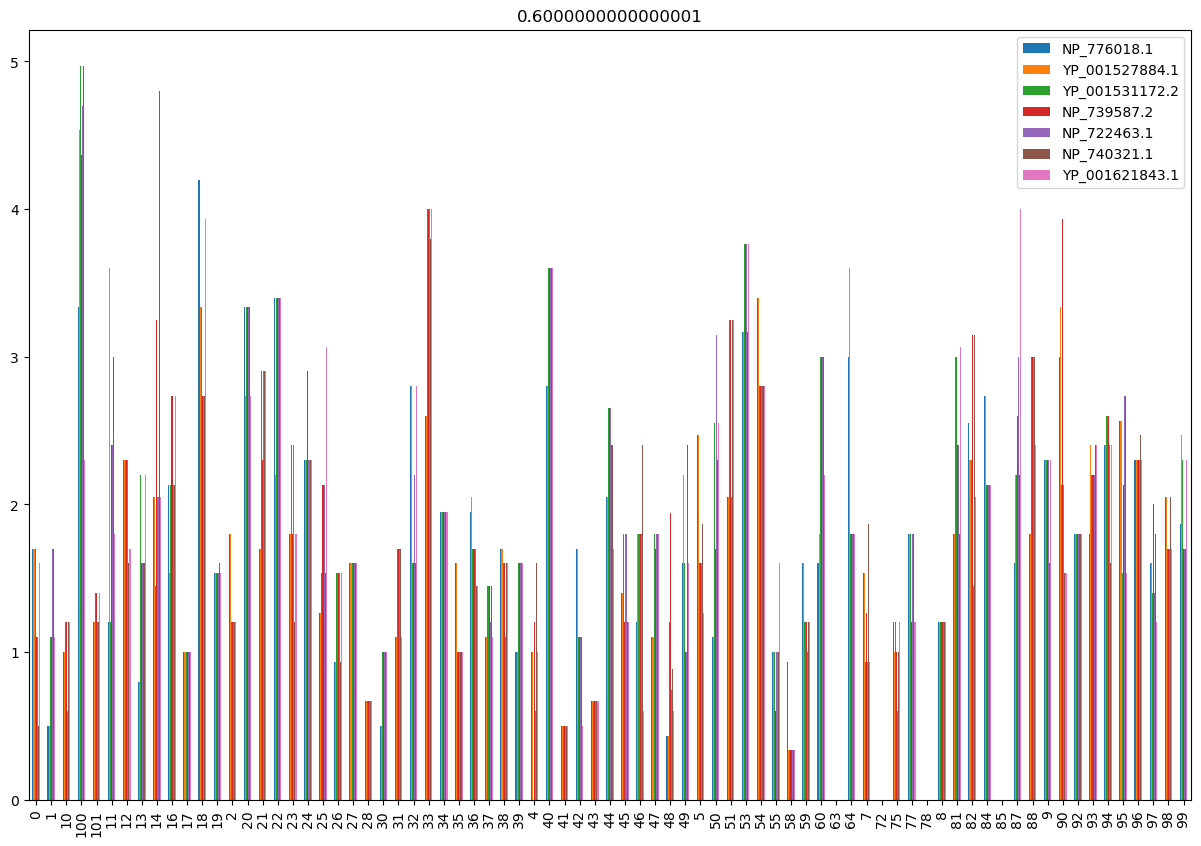

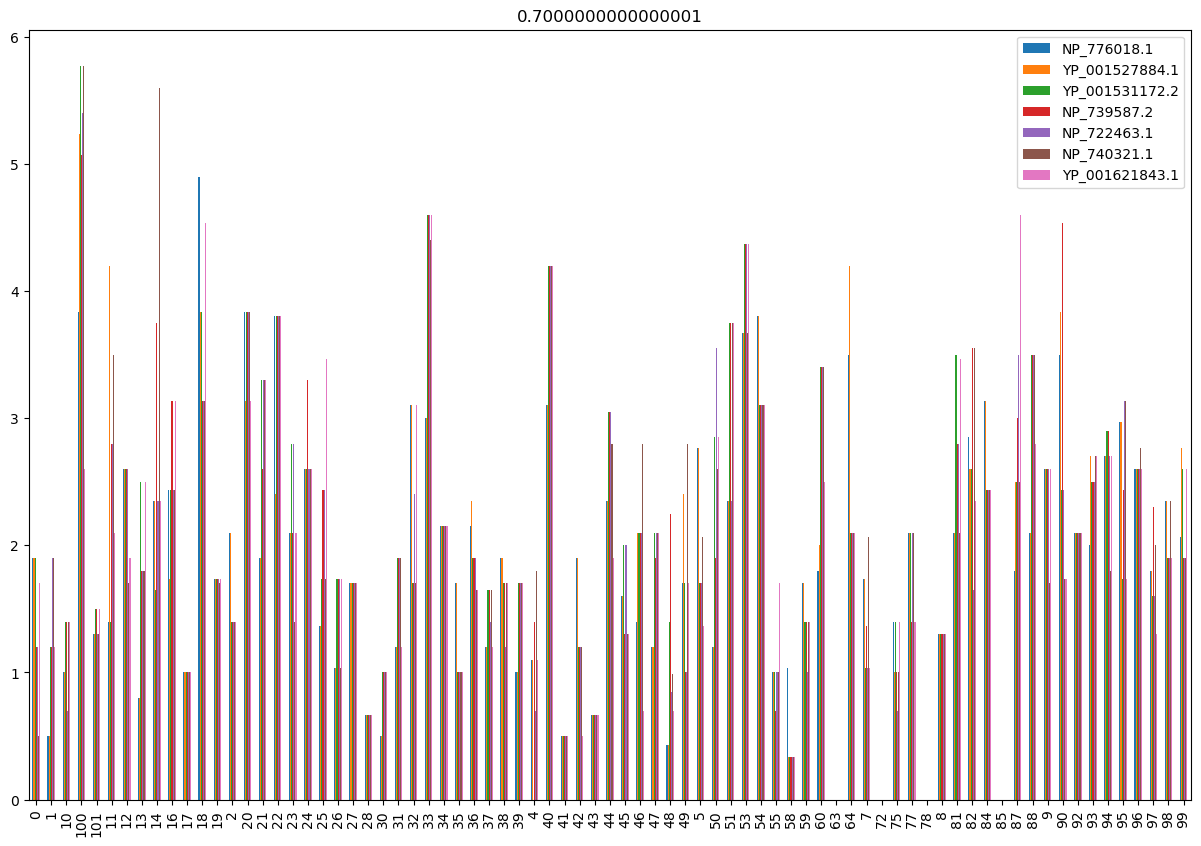

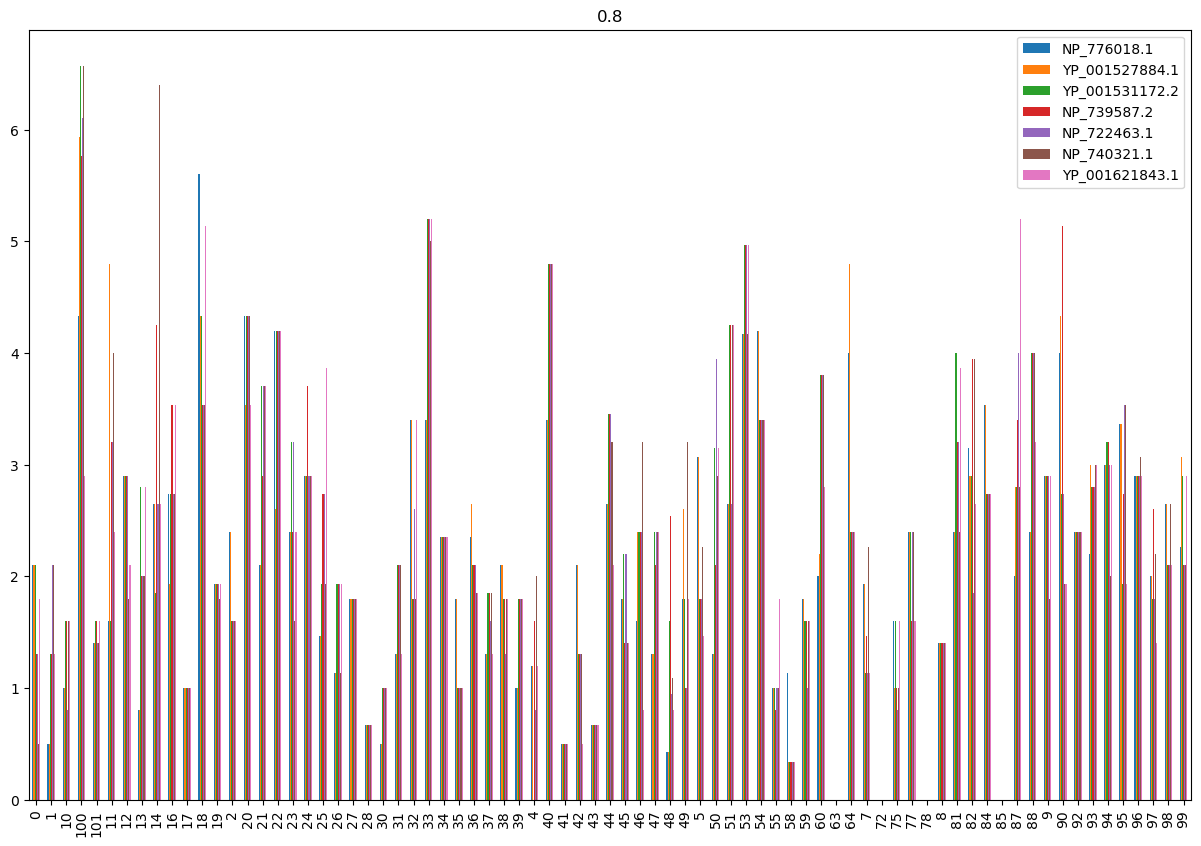

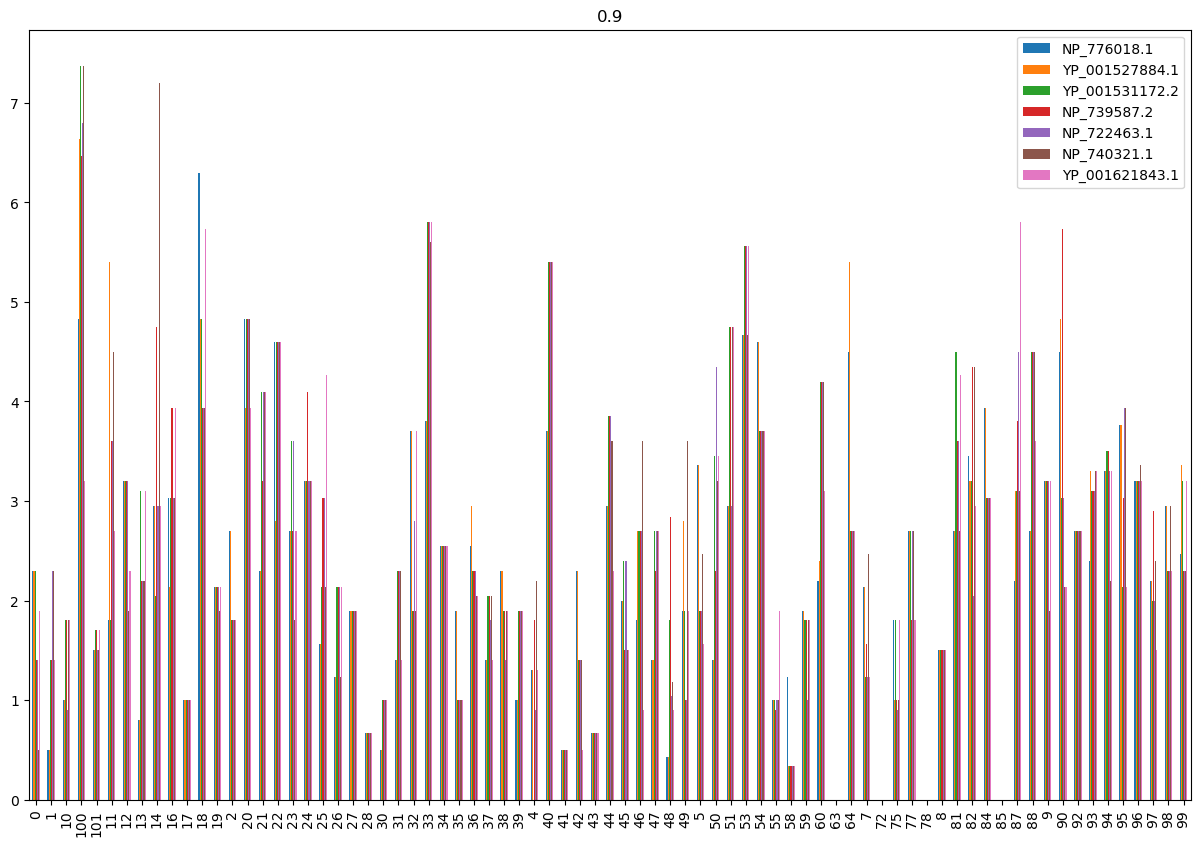

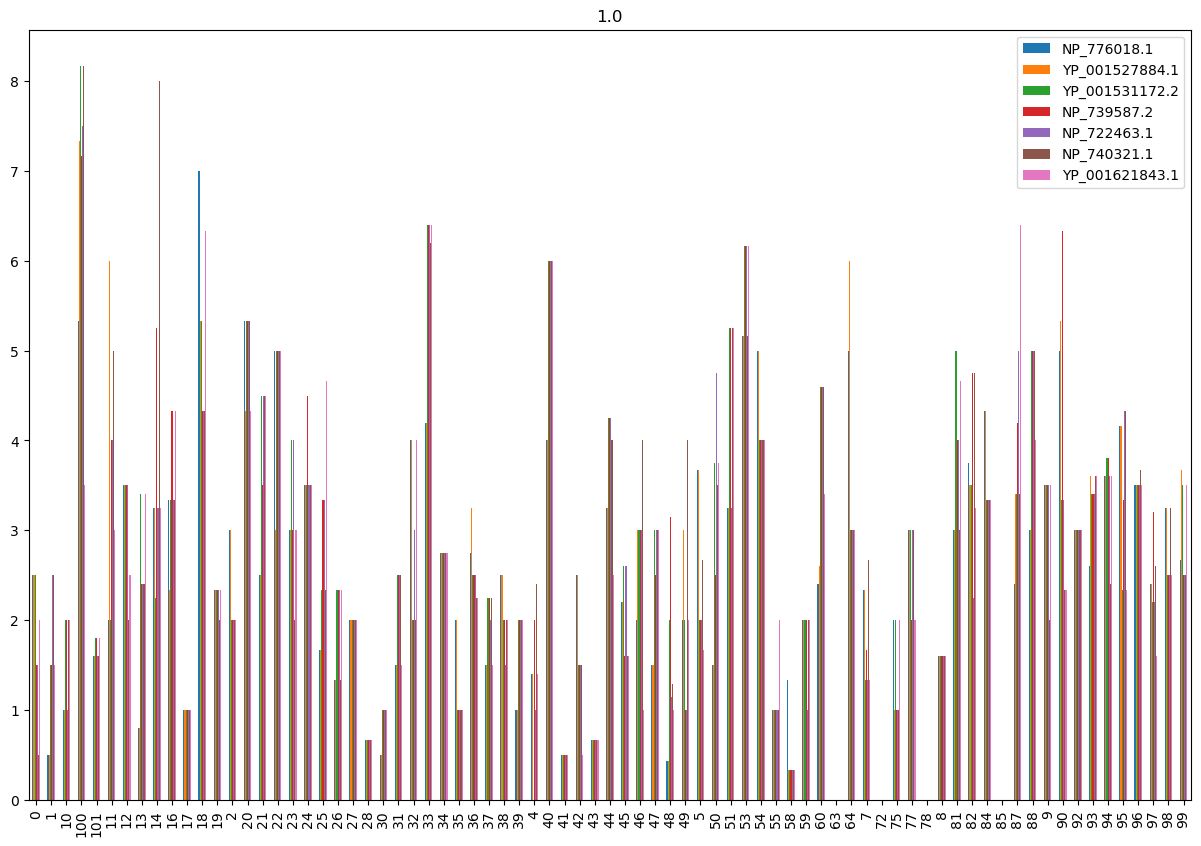

In [20]:
for mu in mu_scores:
    plot_interactions(mu_scores[mu])

In [21]:
# See which positions have the most interactions with ligands
lig_res = dict()
lig_df_res = dict()

for lig in ligand_interactions:
    matrix = np.zeros((8, 195))
    for prot in lig_prot_bitmap[lig]:
        matrix = np.add(matrix, lig_prot_bitmap[lig][prot])
    lig_res[lig] = matrix
    # Get this in a dataframe to plot
    df = pds.DataFrame(lig_res[lig])
    # remove all zero columns
    df = df.loc[:, (df != 0).any(axis=0)]
    lig_df_res[lig] = df

In [22]:
index_interactions = dict((v,k) for k,v in interactions_index.items())
index_interactions

{1: 'hydrophobic_interaction',
 2: 'hydrogen_bond',
 3: 'water_bridge',
 4: 'salt_bridge',
 5: 'pi_stack',
 6: 'pi_cation_interaction',
 7: 'halogen_bond',
 8: 'metal_complex'}

<Axes: >

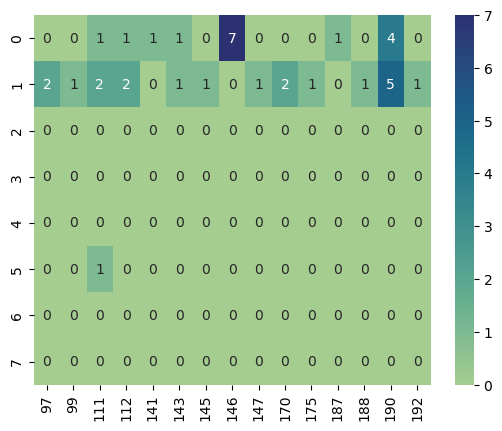

In [23]:
df_plot = lig_df_res['14'].rename(columns=index_interactions)
sns.heatmap(df_plot, annot=True,cmap="crest")

In [24]:
## TODO: Would need to have the residues mapped to this to see which number matched to which residues

## Would like to put all scores generated into one dataframe so can compare between
https://plotly.com/python/splom/

In [25]:
# Read this in from csv 
filepath = '/home/pengs/fold_zika/compare_scores.csv'
compare_scores = pds.read_csv(filepath,index_col=0)

In [26]:
new_scores = pds.DataFrame()
new_scores['tanimoto_mean'] = tanimoto_summary['mean']
new_scores['preserve_in_new_same_residue_mean'] = union_ref_summary['mean']
new_scores

tanimoto_mean  preserve_in_new_same_residue_mean
0         0.369048                           0.571429
1         0.357143                           0.500000
10        0.285714                           0.285714
100       0.159935                           0.309524
101       0.571429                           0.685714
..             ...                                ...
95        0.188889                           0.285714
96        0.349206                           0.523810
97        0.272959                           0.371429
98        0.251701                           0.392857
99        0.390873                           0.547619

[77 rows x 2 columns]

In [27]:
new_scores.index=new_scores.index.astype('int64')

In [28]:
all_scores = pds.concat([new_scores, compare_scores],axis=1)
all_scores

tanimoto_mean  preserve_in_new_same_residue_mean  rmsd_mean  \
0         0.369048                           0.571429   4.055237   
1         0.357143                           0.500000   3.770930   
10        0.285714                           0.285714  10.287188   
100       0.159935                           0.309524   8.169316   
101       0.571429                           0.685714   4.934367   
..             ...                                ...        ...   
95        0.188889                           0.285714   6.241929   
96        0.349206                           0.523810   5.066051   
97        0.272959                           0.371429   6.094942   
98        0.251701                           0.392857   4.218546   
99        0.390873                           0.547619   4.955612   

     interaction_jaccard_mean  interactions_count_jaccard_mean      fint  \
0                    0.479167                         0.625000  6.450000   
1                    0.208333                         0.208333  6.583750   
10                   0.250000                         0.416667  7.100000   
100                  0.250000                         0.593750  6.696905   
101                  0.083333                         0.166667  7.234000   
..                        ...                              ...       ...   
95                   0.187500                         0.625000  6.915000   
96                   0.000000                         0.041667  6.406429   
97                   0.125000                         0.458333  6.334000   
98                   0.291667                         0.708333  6.700000   
99                   0.000000                         0.208333  6.763214   

         intn  
0    5.240000  
1    5.720000  
10   6.360000  
100  7.460000  
101  4.942000  
..        ...  
95   7.028000  
96   4.662857  
97   5.994000  
98   4.840000  
99   4.725357  

[77 rows x 7 columns]

In [29]:
all_scores.nlargest(5, ['tanimoto_mean',
 'preserve_in_new_same_residue_mean',
 'fint',
 'intn'])

tanimoto_mean  preserve_in_new_same_residue_mean  rmsd_mean  \
17       1.000000                           1.000000   2.908441   
35       0.904762                           1.000000   3.631182   
30       0.857143                           0.857143   4.260965   
55       0.785714                           0.857143   4.695979   
27       0.750000                           1.000000   2.991339   

    interaction_jaccard_mean  interactions_count_jaccard_mean      fint  \
17                    0.0000                         0.125000  6.589375   
35                    0.0000                         0.125000  6.267500   
30                    0.1250                         0.125000  6.505000   
55                    0.1875                         0.687500  7.300000   
27                    0.0000                         0.291667  5.905000   

        intn  
17  4.837000  
35  4.620000  
30  4.600000  
55  5.600000  
27  4.331667

In [30]:
all_scores.nsmallest(5, ['tanimoto_mean',
 'preserve_in_new_same_residue_mean',
 'fint',
 'intn'])

tanimoto_mean  preserve_in_new_same_residue_mean  rmsd_mean  \
77            0.0                                0.0   9.255214   
11            0.0                                0.0   7.298246   
46            0.0                                0.0   4.445722   
64            0.0                                0.0   7.593451   
23            0.0                                0.0   8.721284   

    interaction_jaccard_mean  interactions_count_jaccard_mean      fint  \
77                  0.416667                         0.750000  5.973906   
11                  0.447917                         0.812500  6.130000   
46                  0.062500                         0.812500  6.520000   
64                  0.041667                         0.562500  6.575000   
23                  0.125000                         0.458333  6.600000   

       intn  
77  5.31000  
11  2.82418  
46  6.56000  
64  4.67500  
23  4.53600

In [31]:
all_scores.nsmallest(5, ['rmsd_mean',
 'interaction_jaccard_mean',
 'interactions_count_jaccard_mean'])

tanimoto_mean  preserve_in_new_same_residue_mean  rmsd_mean  \
5        0.545238                           0.809524   2.575586   
43       0.666667                           0.666667   2.668684   
33       0.148629                           0.314286   2.780259   
22       0.219048                           1.000000   2.904680   
17       1.000000                           1.000000   2.908441   

    interaction_jaccard_mean  interactions_count_jaccard_mean      fint   intn  
5                   0.291667                         0.333333  6.180000  7.800  
43                  0.000000                         0.000000  5.720000  4.160  
33                  0.000000                         0.583333  6.613750  7.950  
22                  0.437500                         0.437500  7.300000  8.000  
17                  0.000000                         0.125000  6.589375  4.837

In [32]:
all_scores.nlargest(5, ['rmsd_mean',
 'interaction_jaccard_mean',
 'interactions_count_jaccard_mean'])

tanimoto_mean  preserve_in_new_same_residue_mean  rmsd_mean  \
10       0.285714                           0.285714  10.287188   
77       0.000000                           0.000000   9.255214   
47       0.130952                           0.214286   9.133583   
72       0.000000                                NaN   8.964507   
23       0.000000                           0.000000   8.721284   

    interaction_jaccard_mean  interactions_count_jaccard_mean      fint   intn  
10                  0.250000                         0.416667  7.100000  6.360  
77                  0.416667                         0.750000  5.973906  5.310  
47                  0.375000                         0.375000  7.010000  6.590  
72                  0.125000                         0.125000  1.000000  0.600  
23                  0.125000                         0.458333  6.600000  4.536

## Plot all the different scores and see how they compare
https://plotly.com/python/splom/

In [33]:
import plotly.graph_objects as go
import plotly.express as px

In [34]:
list(all_scores.columns)

['tanimoto_mean',
 'preserve_in_new_same_residue_mean',
 'rmsd_mean',
 'interaction_jaccard_mean',
 'interactions_count_jaccard_mean',
 'fint',
 'intn']

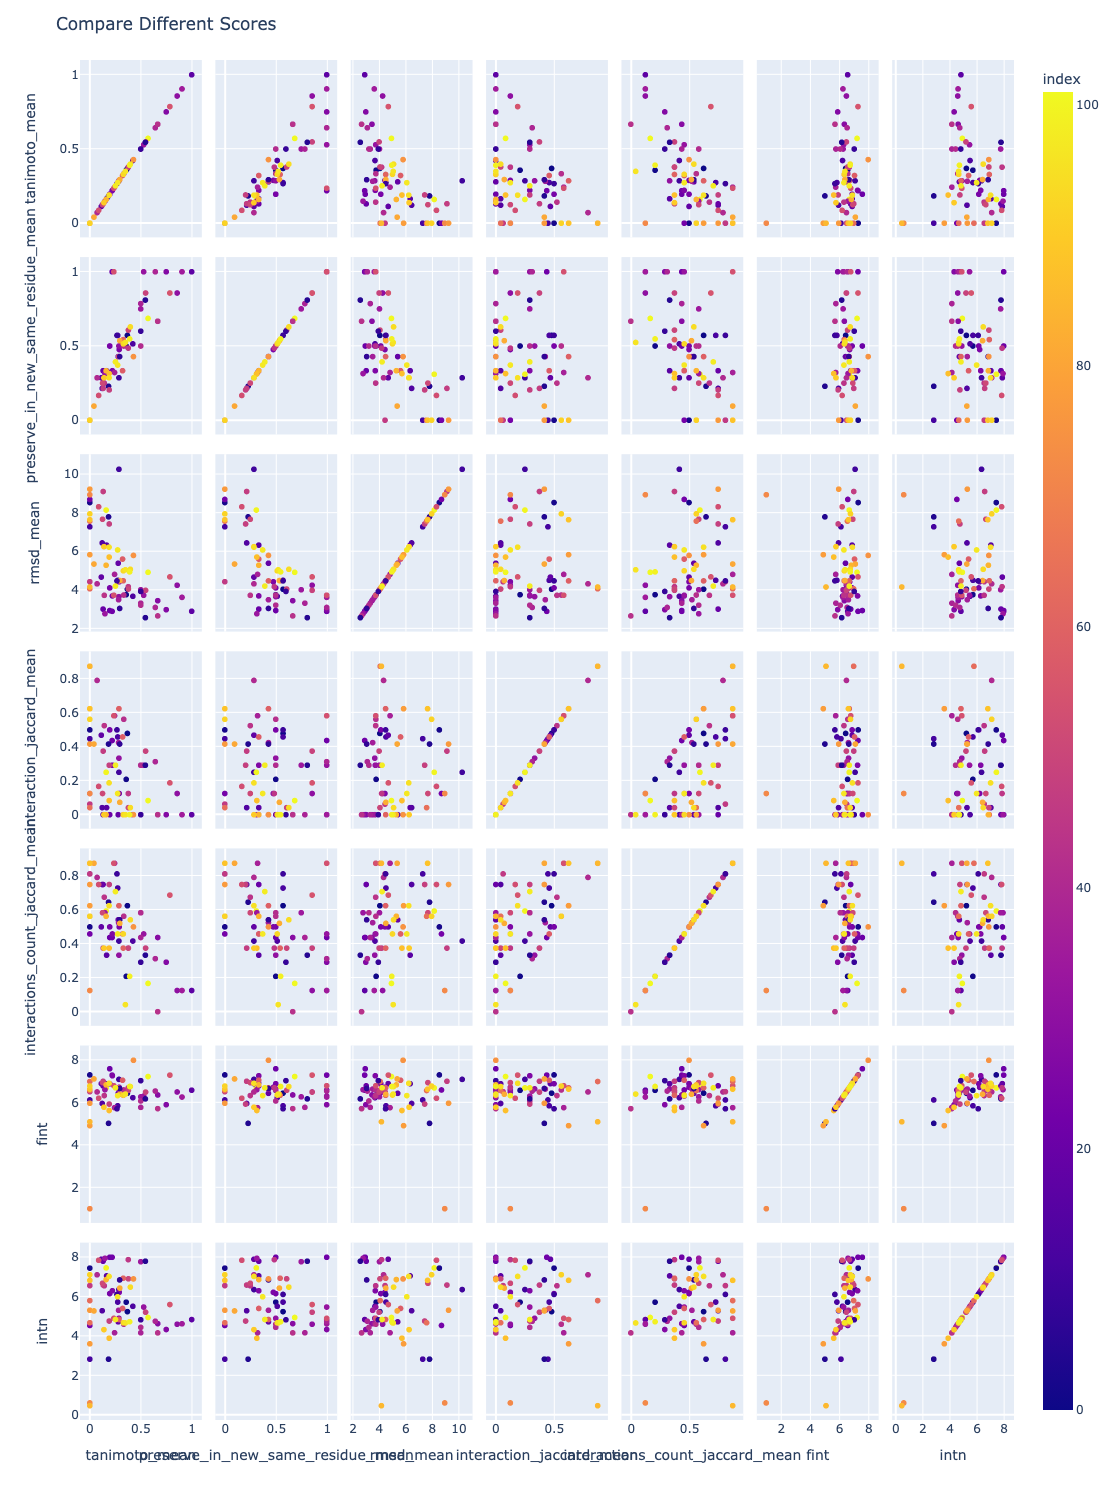

In [35]:
index_vals = all_scores.index

fig = px.scatter_matrix(all_scores,
    dimensions=list(all_scores.columns),
    color=all_scores.index)

fig.update_layout(
     title='Compare Different Scores',
     width=1500,
     height=1500,
 )

fig.show()

In [36]:
fig.write_image(fig_dir/'score_comparison.png')